# Introduction

* Comparison of the surface plots of *a posteriori* test for LSTM and NODE.
* The parameters selected in the code is for the F2R32 case. Update accordingly for the other cases.

In [1]:
import numpy as np
from sklearn import metrics
from scipy import interpolate


import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick

from scipy import ndimage

import os.path

# Start main

## Set parameters & hyperparameters

In [2]:
def metric_r2(y, yhat):
    R2 = np.zeros((y.shape[1]))
    for i in range(y.shape[1]):
        R2[i] = (1 - metrics.r2_score(y[:,i], yhat[:,i])) * 100
    return R2

def metric_nrms(y, yhat):
    # nRMSE = np.linalg.norm(y.reshape(y.shape[0], -1) - yhat.reshape(yhat.shape[0], -1), ord=2, axis=1) / np.linalg.norm(y.reshape(y.shape[0], -1), ord=2, axis=1)
    # nRMSE = np.mean(nRMSE*100)
    nRMSE = np.linalg.norm(y - yhat, 2, axis=0) * 100 / np.linalg.norm(y, 2, axis=0)
    # nRMSE = np.sqrt(np.mean((y - yhat)**2, axis=0)) * 100 / np.sqrt(np.mean(y**2, axis=0))
    return nRMSE

def metric_nabs(y, yhat):
    nABS = np.linalg.norm(y - yhat, 1, axis=0) * 100 / np.linalg.norm(y, 1, axis=0)
    # nABS = np.mean(np.abs(y - yhat), axis=0) * 100 / np.mean(np.abs(y), axis=0)
    return nABS

### Aposteriori results

In [3]:
# **************TEST: LSTM*********************

list_seq_len_lstm = [8, 12, 16, 20, 24, 28, 32, 36, 40, 44,
                48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 
                88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128]
list_batch_size = [10, 10, 10, 10, 10, 10, 10, 10, 10, 50, 
                   50, 50, 50, 50, 50, 100, 100, 100, 100, 100, 
                   100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
list_dt_T_lstm = [0.02, 0.05, 0.07, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 
             0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 
             1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 
             1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0]
target_T = 1.0
stateID = 3
state_plt = ['KE_h', 'KE_v', 'PE', 'bw']
list_r2_lstm = np.zeros((len(list_dt_T_lstm), len(list_seq_len_lstm))) * np.nan
list_r2all_lstm = np.zeros((len(list_dt_T_lstm), len(list_seq_len_lstm), 4)) * np.nan
list_nrms_lstm = np.zeros((len(list_dt_T_lstm), len(list_seq_len_lstm), 4)) * np.nan
list_abs_lstm = np.zeros((len(list_dt_T_lstm), len(list_seq_len_lstm), 4)) * np.nan

low_seq_counter = 0
low_seqID_seq = []
low_seqID_dt_T = []
unrunID_seq = []
unrunID_dt_T = []
unrun_counter = 0
run_counter = 0
for i in range(len(list_dt_T_lstm)):
    for j in range(len(list_seq_len_lstm)):
        dt_target = target_T/list_seq_len_lstm[j]
        seq_len = np.max([int(list_dt_T_lstm[i]/dt_target), 1])
        if seq_len!=1:
            # filename = f'Data_models/Out_PhydtmEnergy1_interpIO1_setdt1-T{list_dt_T[i]}_'\
            filename = f'Data_models/Out_PhydtmEnergy1_interpIO1_setdt1-T{list_dt_T_lstm[i]}_'\
                       f'IPtime0_IPKEPEtime0_IPFrGn0_F2R32_PyTModel_LSTM_seqlen{seq_len}_'\
                       f'nLSTMLayers4_hiddensize10_nMLPLayers1_nNeurons15_batch{list_batch_size[j]}_'\
                       f'lr0.001_scaleDataFalse_nin4_Ntrain0.9_nepoch4000_ODE_testdata_F2R32_tout25.0_toff5.0'
            datapath = f'{filename}.npz'
            if os.path.isfile(datapath):
                run_counter += 1
                npzfile = np.load(datapath)
                test_time = npzfile['test_time']
                q_true = npzfile['q_true']
                t         = npzfile['t']
                q_ODE     = npzfile['q_ODE']
                q_ML      = npzfile['q_ML']
                data_op_varnames = npzfile['data_op_varnames']
                n_outputs = q_true.shape[1]
                tempID = [t[:]<test_time[-1]][0]
                # Check for NaN: some values maybe NaN due to the model being unstable
                if not(np.isnan(q_ODE[tempID,:].flatten()).any() or np.isnan(q_ML[tempID,:].flatten()).any()): 
                    list_r2_lstm[i,j] = metrics.r2_score(q_ODE[tempID,stateID], q_ML[tempID,stateID])
                    list_r2all_lstm[i,j,:] = metric_r2(q_ODE[tempID,:], q_ML[tempID,:])
                    list_nrms_lstm[i,j,:] = metric_nrms(q_ODE[tempID,:], q_ML[tempID,:])
                    list_abs_lstm[i,j,:] = metric_nabs(q_ODE[tempID,:], q_ML[tempID,:])
            else:
                # print(f'Issue with case: seq_len {list_seq_len[j]}, dt_T {list_dt_T[i]}')
                unrunID_seq.append(j)
                unrunID_dt_T.append(i)
                unrun_counter += 1
        else:
            low_seqID_seq.append(j)
            low_seqID_dt_T.append(i)
            low_seq_counter += 1

print(f'unrun: {unrun_counter}, low_seq: {low_seq_counter}, run: {run_counter}')

unrun: 1, low_seq: 45, run: 1287


In [4]:
# Line plots
# i = 12; j = 14
# print(f'{list_dt_T_lstm[i]}, {list_seq_len_lstm[j]}, {list_batch_size[j]}, {prop[i,j]}')

# dt_target = target_T/list_seq_len_lstm[j]
# seq_len = int(list_dt_T_lstm[i]/dt_target)
# filename = f'Data_models/Out_PhydtmEnergy1_interpIO1_setdt1-T{list_dt_T_lstm[i]}_'\
#            f'IPtime0_IPKEPEtime0_IPFrGn0_F2R32_PyTModel_LSTM_seqlen{seq_len}_'\
#            f'nLSTMLayers4_hiddensize10_nMLPLayers1_nNeurons15_batch{list_batch_size[j]}_'\
#            f'lr0.001_scaleDataFalse_nin4_Ntrain0.9_nepoch4000_ODE_testdata_F2R32_tout15.0_toff15.0'
# datapath = f'{filename}.npz'
# npzfile = np.load(datapath)
# test_time = npzfile['test_time']
# q_true = npzfile['q_true']
# t         = npzfile['t']
# q_ODE     = npzfile['q_ODE']
# q_ML      = npzfile['q_ML']
# data_op_varnames = npzfile['data_op_varnames']
# n_outputs = q_true.shape[1]
# tempID = [t[:]<test_time[-1]][0]
# print(f'r2 = {metric_r2(q_ODE[tempID,:], q_ML[tempID,:])}\nnrms = {metric_nrms(q_ODE[tempID,:], q_ML[tempID,:])}\nnabs = {metric_nabs(q_ODE[tempID,:], q_ML[tempID,:])}')

# # interpolate q_true to time_LSTM
# finterp = interpolate.interp1d(test_time, q_true, axis=0, kind='cubic', fill_value="extrapolate")
# q_true_LSTM_interp = finterp(t)
# state_plt = ['KE_h', 'KE_v', 'PE', 'bw']

# plt.rcParams.update({'font.size': 15})
# # plt.style.use('classic'), plt.style.use('style_mgm')
# fig, axs = plt.subplots(3,2,figsize=(20,15),sharex=True,facecolor="1")
# axs = axs.ravel()
# for i in range(4):
#     axs[i].plot(test_time, q_true[:,i], '-k')
#     axs[i].plot(t, q_ML[:,i], '-r')
#     tempID = [t[:]<test_time[-1]][0]
#     r2 = metric_nrms(q_ODE[tempID,i],q_ML[tempID,i])
#     axs[i].set_title(r''+state_plt[i]+', $NRMS$ (per) $= %0.2f$' % r2)
# axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
# axs[0].set_ylabel(r'$E_i$'); axs[2].set_ylabel(r'$E_i$');

# totalE_qtrue = np.sum(q_true[:,0:3], axis=1)
# axs[4].plot(test_time, totalE_qtrue, '-', color='black', linewidth=1.8, label='True')
# # axs[4].plot(t, totalE_qtrue, '--', color='tab:red', linewidth=1.8, label='using true RHS')
# totalE_ML = np.sum(q_ML[:,0:3], axis=1)
# axs[4].plot(t, totalE_ML, '--', color='tab:blue', linewidth=1.8, label='NN')
# axs[4].set_xlabel(r'time')
# axs[4].set_title(r'Total $E = E_v + E_h + E_p$');
# axs[-1].axis('off')

# # plt.savefig(f'Figs/Compare_parametric_seq-T_lineplots_0shift.png', bbox_inches='tight') 

In [5]:
# **************TEST: NODE*********************

list_seq_len_node = [8, 12, 16, 20, 24, 28, 32, 36, 40, 44,
                48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 
                88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128]
list_batch_size = [10, 10, 10, 10, 10, 10, 10, 10, 10, 50, 
                   50, 50, 50, 50, 50, 100, 100, 100, 100, 100, 
                   100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
list_dt_T_node = [0.02, 0.05, 0.07, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 
             0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 
             1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 
             1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0]
target_T = 1.0
stateID = 3
state_plt = ['KE_h', 'KE_v', 'PE', 'bw']
list_r2_node = np.zeros((len(list_dt_T_node), len(list_seq_len_node))) * np.nan
list_r2all_node = np.zeros((len(list_dt_T_node), len(list_seq_len_node), 4)) * np.nan
list_nrms_node = np.zeros((len(list_dt_T_node), len(list_seq_len_node), 4)) * np.nan
list_abs_node = np.zeros((len(list_dt_T_node), len(list_seq_len_node), 4)) * np.nan

low_seq_counter = 0
low_seqID_seq = []
low_seqID_dt_T = []
unrunID_seq = []
unrunID_dt_T = []
unrun_counter = 0
run_counter = 0
for i in range(len(list_dt_T_node)):
    for j in range(len(list_seq_len_node)):
        dt_target = target_T/list_seq_len_node[j]
        seq_len = np.max([int(list_dt_T_node[i]/dt_target), 1])
        if seq_len>1:
            # filename = f'Data_models/Out_PhydtmEnergy1_interpIO1_setdt1-T{list_dt_T[i]}_'\
            filename = f'Data_models/Out_normEnergy1_interpIO1_setdt1-T{list_dt_T_node[i]}_'\
                       f'IPtime0_IPKEPEtime0_IPFrGn0_F2R32_PyTModel_NODE_MLP_seqlen{seq_len}_'\
                       f'nMLPLayers10_nNeurons40_batch{list_batch_size[j]}_'\
                       f'lr0.05_scaleDataFalse_nin4_Ntrain0.9_nepoch1000_ODE_testdata_F2R32_tout30.0_toff0.0'
            datapath = f'{filename}.npz'
            if os.path.isfile(datapath):
                run_counter += 1
                npzfile = np.load(datapath)
                test_time = npzfile['test_time']
                q_true = npzfile['q_true']
                t         = npzfile['t']
                q_ODE     = npzfile['q_ODE']
                q_ML      = npzfile['q_ML']
                data_op_varnames = npzfile['data_ip_varnames']
                n_outputs = q_true.shape[1]
                tempID = [t[:]<test_time[-1]][0]
                # Check for NaN: some values maybe NaN due to the model being unstable
                if not(np.isnan(q_ODE[tempID,:].flatten()).any() or np.isnan(q_ML[tempID,:].flatten()).any()): 
                    list_r2_node[i,j] = metrics.r2_score(q_ODE[tempID,stateID], q_ML[tempID,stateID])
                    list_r2all_node[i,j,:] = metric_r2(q_ODE[tempID,:], q_ML[tempID,:])
                    list_nrms_node[i,j,:] = metric_nrms(q_ODE[tempID,:], q_ML[tempID,:])
                    list_abs_node[i,j,:] = metric_nabs(q_ODE[tempID,:], q_ML[tempID,:])
            else:
                # print(f'Issue with case: seq_len {list_seq_len[j]}, dt_T {list_dt_T[i]}')
                unrunID_seq.append(j)
                unrunID_dt_T.append(i)
                unrun_counter += 1
        else:
            low_seqID_seq.append(j)
            low_seqID_dt_T.append(i)
            low_seq_counter += 1

print(f'unrun: {unrun_counter}, low_seq: {low_seq_counter}, run: {run_counter}')

unrun: 0, low_seq: 45, run: 1288


In [6]:
# Line plots
# i = 24; j = 14
# print(f'{list_dt_T_node[i]}, {list_seq_len_node[j]}, {list_batch_size[j]}, {prop[i,j]}')

# dt_target = target_T/list_seq_len_node[j]
# seq_len = int(list_dt_T_node[i]/dt_target)
# filename = f'Data_models/Out_normEnergy1_interpIO1_setdt1-T{list_dt_T_node[i]}_'\
#            f'IPtime0_IPKEPEtime0_IPFrGn0_F2R32_PyTModel_NODE_MLP_seqlen{seq_len}_'\
#            f'nMLPLayers10_nNeurons40_batch{list_batch_size[j]}_'\
#            f'lr0.05_scaleDataFalse_nin4_Ntrain0.9_nepoch1000_ODE_testdata_F2R32_tout30.0_toff0.0'
# datapath = f'{filename}.npz'
# npzfile = np.load(datapath)
# test_time = npzfile['test_time']
# q_true = npzfile['q_true']
# t         = npzfile['t']
# q_ODE     = npzfile['q_ODE']
# q_ML      = npzfile['q_ML']
# data_op_varnames = npzfile['data_ip_varnames']
# n_outputs = q_true.shape[1]
# tempID = [t[:]<test_time[-1]][0]
# print(f'r2 = {metric_r2(q_ODE[tempID,:], q_ML[tempID,:])}\nnrms = {metric_nrms(q_ODE[tempID,:], q_ML[tempID,:])}\nnabs = {metric_nabs(q_ODE[tempID,:], q_ML[tempID,:])}')

# # interpolate q_true to time_LSTM
# finterp = interpolate.interp1d(test_time, q_true, axis=0, kind='cubic', fill_value="extrapolate")
# q_true_LSTM_interp = finterp(t)
# state_plt = ['KE_h', 'KE_v', 'PE', 'bw']

# plt.rcParams.update({'font.size': 15})
# # plt.style.use('classic'), plt.style.use('style_mgm')
# fig, axs = plt.subplots(3,2,figsize=(20,15),sharex=True,facecolor="1")
# axs = axs.ravel()
# for i in range(4):
#     axs[i].plot(test_time, q_true[:,i], '-k')
#     axs[i].plot(t, q_ML[:,i], '-r')
#     tempID = [t[:]<test_time[-1]][0]
#     r2 = metric_nrms(q_ODE[tempID,i],q_ML[tempID,i])
#     axs[i].set_title(r''+state_plt[i]+', $NRMS$ (per) $= %0.2f$' % r2)
# axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
# axs[0].set_ylabel(r'$E_i$'); axs[2].set_ylabel(r'$E_i$');

# totalE_qtrue = np.sum(q_true[:,0:3], axis=1)
# axs[4].plot(test_time, totalE_qtrue, '-', color='black', linewidth=1.8, label='True')
# # axs[4].plot(t, totalE_qtrue, '--', color='tab:red', linewidth=1.8, label='using true RHS')
# totalE_ML = np.sum(q_ML[:,0:3], axis=1)
# axs[4].plot(t, totalE_ML, '--', color='tab:blue', linewidth=1.8, label='NN')
# axs[4].set_xlabel(r'time')
# axs[4].set_title(r'Total $E = E_v + E_h + E_p$');
# axs[-1].axis('off')

# # plt.savefig(f'Figs/Compare_parametric_seq-T_lineplots_0shift.png', bbox_inches='tight') 

In [7]:
saveFig = True

### Surface plots

dt: 0.026, T: 0.45, Re: 17.1


/tmp/ipykernel_1151/212392832.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=-90)


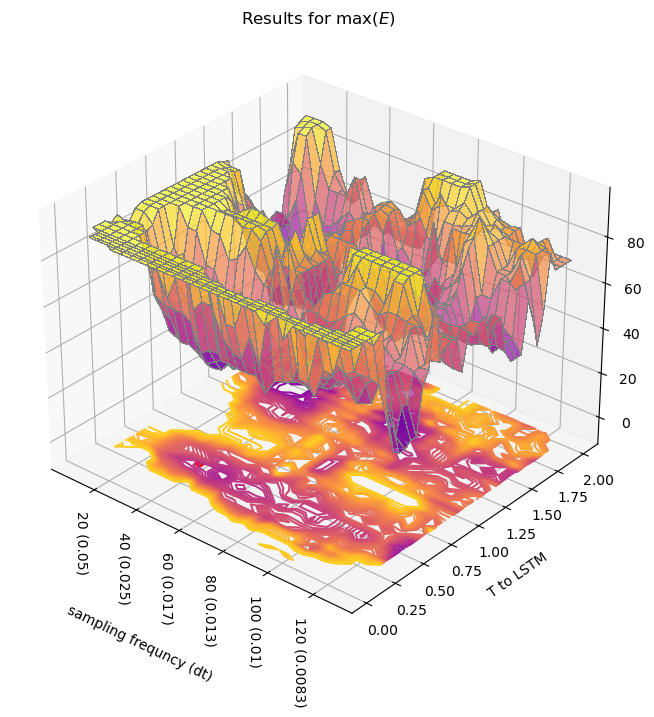

In [8]:
# prop = np.copy(list_nrms[:, :, stateID])
prop = np.max(list_nrms_lstm, axis=2)
# xx, yy = np.meshgrid(list_dt_target, list_dt_T)
xx, yy = np.meshgrid(list_seq_len_lstm, list_dt_T_lstm)

propth_lo = 0.0
propth_hi = 90.0
tempID1, tempID2 = np.where(prop<propth_lo)# and np.where(prop>propth_hi)
prop[tempID1, tempID2] = propth_lo
tempID1, tempID2 = np.where(prop>propth_hi)# and np.where(prop>propth_hi)
prop[tempID1, tempID2] = propth_hi

# a uniform (boxcar) filter with a width of 50
boxcar = ndimage.uniform_filter1d(prop, 3, 1)
# a Gaussian filter with a standard deviation of 10
gauss = ndimage.gaussian_filter1d(prop, 2, 1)
# a Median filter
median = ndimage.median_filter(prop, 7)

prop_plt = median
clevels = np.linspace(0, 100, 100)

fig = plt.figure(figsize=(8,8),facecolor="1")
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.plasma
ax.plot_surface(xx, yy, prop_plt, alpha=0.7, linewidth=0.1, edgecolors=[0.5,0.5,0.5], 
                cmap=cmap, antialiased=False, shade=False, rstride=1, cstride=1)
zlims = [-10, propth_hi*1.1]
xlims = [-10, np.max(xx)*1.1]
ylims = [-0.2, np.max(yy)*1.1]
cset = ax.contour(xx, yy, prop_plt, levels=clevels, zdir='z', offset=zlims[0], cmap=cmap)
# cset = ax.contourf(xx, yy, prop_plt, zdir='x', offset=xlims[0], cmap=cm.coolwarm)
# cset = ax.contourf(xx, yy, prop_plt, zdir='y', offset=ylims[1], cmap=cm.coolwarm)

df = 38
T = 0.45
dt = (target_T / df)
Re = T / dt
print(f'dt: {dt:0.2}, T: {T}, Re: {Re:0.3}')
ax.plot(df, T, zlims[0], 'or')

ax.set_zlim(zlims)
# ax.set_xlim([0, 80])
# ax.set_ylim([0, 1.5])

ax.set_ylabel('\nT to LSTM')
ax.set_zlabel(f'$NRMS$')
ax.set_xlabel('sampling frequency')

# ax.set_title(f'Results for ${state_plt[stateID]}$')
ax.set_title(f'Results for $\max(E)$')

labels = [float(item.get_text()) for item in ax.get_xticklabels()]
labels = [f'{int(labels[i])} ({target_T/(labels[i]+1e-15):0.2})' for i in range(len(labels))]
ax.set_xticklabels(labels, rotation=-90)
ax.set_xlabel('\n \n \n \n \n \n \n \nsampling frequency (dt)')

ax.view_init(30, 310)
# ax.view_init(30, 500)

# if saveFig: plt.savefig(f'Figs/Compare_parametric_seq-T_Filtered-surfaceplot_state{state_plt[stateID]}.png', bbox_inches='tight') #,dpi=100)

if saveFig: plt.savefig(f'Figs/Compare_parametric_seq-T_Filtered-surfaceplot_apost_15shift_maxAll_Phy_LSTM_F2R32.png', bbox_inches='tight')

dt: 0.029, T: 0.8, Re: 28.0


/tmp/ipykernel_1151/3293680991.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=-90)


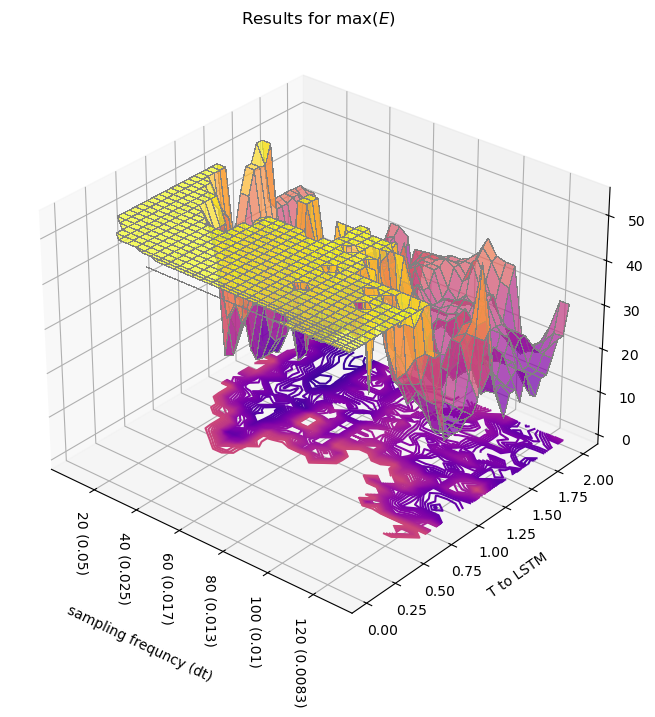

In [9]:
# prop = np.copy(list_nrms[:, :, stateID])
prop = np.max(list_nrms_node, axis=2)
# xx, yy = np.meshgrid(list_dt_target, list_dt_T)
xx, yy = np.meshgrid(list_seq_len_node, list_dt_T_node)

propth_lo = 0.0
propth_hi = 50.0
tempID1, tempID2 = np.where(prop<propth_lo)# and np.where(prop>propth_hi)
prop[tempID1, tempID2] = propth_lo
tempID1, tempID2 = np.where(prop>propth_hi)# and np.where(prop>propth_hi)
prop[tempID1, tempID2] = propth_hi

# a uniform (boxcar) filter with a width of 50
boxcar = ndimage.uniform_filter1d(prop, 3, 1)
# a Gaussian filter with a standard deviation of 10
gauss = ndimage.gaussian_filter1d(prop, 2, 1)
# a Median filter
median = ndimage.median_filter(prop, 4)

prop_plt = median
fig = plt.figure(figsize=(8,8),facecolor="1")
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.plasma
ax.plot_surface(xx, yy, prop_plt, alpha=0.7, linewidth=0.1, edgecolors=[0.5,0.5,0.5], 
                cmap=cmap, antialiased=False, shade=False, rstride=1, cstride=1)
zlims = [-1, propth_hi*1.1]
xlims = [-10, np.max(xx)*1.1]
ylims = [-0.2, np.max(yy)*1.1]
cset = ax.contour(xx, yy, prop_plt, levels=clevels, zdir='z', offset=zlims[0], cmap=cmap)
# cset = ax.contourf(xx, yy, prop_plt, zdir='x', offset=xlims[0], cmap=cm.coolwarm)
# cset = ax.contourf(xx, yy, prop_plt, zdir='y', offset=ylims[1], cmap=cm.coolwarm)

df = 35
T = 0.8
dt = (target_T / df)
Re = T / dt
print(f'dt: {dt:0.2}, T: {T}, Re: {Re:0.3}')
ax.plot(df, T, zlims[0], 'or')

ax.set_zlim(zlims)
# ax.set_xlim([0, 80])
# ax.set_ylim([0, 1.5])

ax.set_ylabel('\nT to LSTM')
ax.set_zlabel(f'$NRMS$')
ax.set_xlabel('sampling frequency')

# ax.set_title(f'Results for ${state_plt[stateID]}$')
ax.set_title(f'Results for $\max(E)$')

labels = [float(item.get_text()) for item in ax.get_xticklabels()]
labels = [f'{int(labels[i])} ({target_T/(labels[i]+1e-15):0.2})' for i in range(len(labels))]
ax.set_xticklabels(labels, rotation=-90)
ax.set_xlabel('\n \n \n \n \n \n \n \nsampling frequency (dt)')

ax.view_init(30, 310)
# ax.view_init(40, 500)

if saveFig: plt.savefig(f'Figs/Compare_parametric_seq-T_Filtered-surfaceplot_apost_maxAll_NODE_F2R32.png', bbox_inches='tight')

In [10]:
# prop = np.max(list_nrms_node, axis=2)
# xx, yy = np.meshgrid(list_seq_len_node, list_dt_T_node)

# propth_lo = 0.0
# propth_hi = 10.0
# tempID1, tempID2 = np.where(prop<propth_lo)# and np.where(prop>propth_hi)
# prop[tempID1, tempID2] = propth_lo
# tempID1, tempID2 = np.where(prop>propth_hi)# and np.where(prop>propth_hi)
# prop[tempID1, tempID2] = propth_hi
# # a Median filter
# median = ndimage.median_filter(prop, 4)
# prop_plt = median

# fig = plt.figure(figsize=(8,8),facecolor="1")
# ax = fig.add_subplot(111, projection='3d')
# zlims = [0, 1]#propth_hi*1.1]
# xlims = [-10, np.max(xx)*1.1]
# ylims = [-0.2, np.max(yy)*1.1]
# cmap = plt.cm.Reds_r
# cset = ax.contour(xx, yy, prop_plt, levels=clevels, zdir='z', offset=zlims[0], cmap=cmap, alpha=0.8)
# df = 35
# T = 0.8
# dt = (target_T / df)
# Re = T / dt
# print(f'dt: {dt:0.2}, T: {T}, Re: {Re:0.3}')
# ax.plot(df, T, zlims[0], 'or')

# # LSTM
# prop = np.max(list_nrms_lstm, axis=2)
# xx, yy = np.meshgrid(list_seq_len_lstm, list_dt_T_lstm)
# propth_lo = 0.0
# propth_hi = 40.0
# tempID1, tempID2 = np.where(prop<propth_lo)# and np.where(prop>propth_hi)
# prop[tempID1, tempID2] = propth_lo
# tempID1, tempID2 = np.where(prop>propth_hi)# and np.where(prop>propth_hi)
# prop[tempID1, tempID2] = propth_hi
# # a Median filter
# median = ndimage.median_filter(prop, 6)
# prop_plt = median
# cmap = plt.cm.Blues_r
# cset = ax.contour(xx, yy, prop_plt, levels=clevels, zdir='z', offset=zlims[0], cmap=cmap, alpha=0.8)
# df = 38
# T = 0.45
# dt = (target_T / df)
# Re = T / dt
# print(f'dt: {dt:0.2}, T: {T}, Re: {Re:0.3}')
# ax.plot(df, T, zlims[0], 'ob')

# ax.set_zlim(zlims)

# ax.set_ylabel('\nT to LSTM')
# ax.set_zlabel(f'$NRMS$')
# ax.set_xlabel('sampling frequency')

# # ax.set_title(f'Results for ${state_plt[stateID]}$')
# ax.set_title(f'Results for $\max(E)$')

# labels = [float(item.get_text()) for item in ax.get_xticklabels()]
# labels = [f'{int(labels[i])} ({target_T/(labels[i]+1e-15):0.2})' for i in range(len(labels))]
# ax.set_xticklabels(labels, rotation=-90)
# ax.set_xlabel('\n \n \n \n \n \n \n \nsampling frequency (dt)')

# ax.view_init(30, 310)

NODE time-scales: dt=0.029, T=1.9, Re=66.5
LSTM time-scales: dt=0.029, T=1.5, Re=52.5


/tmp/ipykernel_1151/945781602.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


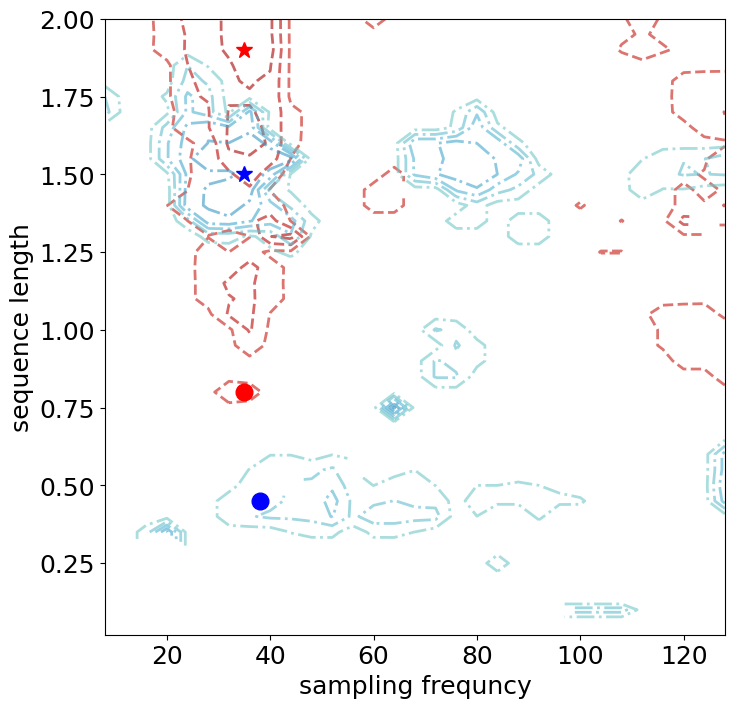

In [12]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(8,8),facecolor="1")
ax = fig.add_subplot(111)

# NODE
prop = np.max(list_nrms_node, axis=2)
xx, yy = np.meshgrid(list_seq_len_node, list_dt_T_node)
propth_lo = 0.0
propth_hi = 20.0
tempID1, tempID2 = np.where(prop<propth_lo)
prop[tempID1, tempID2] = propth_lo
tempID1, tempID2 = np.where(prop>propth_hi)
prop[tempID1, tempID2] = propth_hi
# a Median filter
median = ndimage.median_filter(prop, 4)  #  F2R32: 4, F4R32: 3, F4R64: 3
prop_plt = median
cmap = plt.cm.OrRd_r
clevels = np.linspace(0, 100, 22)
cset = ax.contour(xx, yy, prop_plt, linestyles='--', levels=clevels, cmap=cmap, alpha=0.6, linewidths=2)
df = 35   #  F2R32: 35, F4R32: 35, F4R64: 35
T = 0.8   #  F2R32: 0.8, F4R32: 0.8, F4R64: 0.8
dt = (target_T / df)
Re = T / dt
ax.plot(df, T, color='r', marker='o', markersize=12)
df = 35   #  F2R32: 35, F4R32: 35, F4R64: 35
T = 1.9   #  F2R32: 0.8, F4R32: 0.8, F4R64: 0.8
dt = (target_T / df)
Re = T / dt
print(f'NODE time-scales: dt={dt:0.2}, T={T}, Re={Re:0.3}')
ax.plot(df, T, color='r', marker='*', markersize=12)

# LSTM
prop = np.max(list_nrms_lstm, axis=2)
xx, yy = np.meshgrid(list_seq_len_lstm, list_dt_T_lstm)
propth_lo = 0.0
propth_hi = 50.0
tempID1, tempID2 = np.where(prop<propth_lo)
prop[tempID1, tempID2] = propth_lo
tempID1, tempID2 = np.where(prop>propth_hi)
prop[tempID1, tempID2] = propth_hi
# a Median filter
median = ndimage.median_filter(prop, 6)  # F2R32: 7, F4R32: 6, F4R64: 6
prop_plt = median
cmap = plt.cm.GnBu_r
clevels = np.linspace(0, 100, 22)
cset = ax.contour(xx, yy, prop_plt, linestyles='-.', levels=clevels, cmap=cmap, alpha=0.6, linewidths=2)
df = 38   #  F2R32: 35, F4R32: 38, F4R64: 35
T = 0.45   #  F2R32: 0.8, F4R32: 0.45, F4R64: 0.8
dt = (target_T / df)
Re = T / dt
ax.plot(df, T, color='b', marker='o', markersize=12)
df = 35   #  F2R32: 35, F4R32: 38, F4R64: 35
T = 1.5   #  F2R32: 0.8, F4R32: 0.45, F4R64: 0.8
dt = (target_T / df)
Re = T / dt
print(f'LSTM time-scales: dt={dt:0.2}, T={T}, Re={Re:0.3}')
ax.plot(df, T, color='b', marker='*', markersize=12)

ax.set_ylabel('sequence length')

labels = [float(item.get_text()) for item in ax.get_xticklabels()]
labels = [f'{int(labels[i])}' for i in range(len(labels))]
ax.set_xticklabels(labels, rotation=0)
ax.set_xlabel('sampling frequency');

if saveFig: plt.savefig(f'Figs/Compare_parametric_seq-T_Filtered-surfaceplot_apost_maxAll_NODE-LSTM_F2R32.png', bbox_inches='tight')
if saveFig: plt.savefig(f'Figs/Compare_parametric_NODE-LSTM_F2R32.png', bbox_inches='tight')